## Reference Model

In [1]:
import maxentep
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.stats as ss
plt.style.use('seaborn-darkgrid')
# disabling gpu for now
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
M = 4
R = np.abs(np.random.normal(size=(M,M), loc=1.25))
R = R / np.sum(R, axis=1).reshape(M,1)
R, np.sum(R, axis=1)

(array([[0.1452849 , 0.27368488, 0.48326817, 0.09776204],
        [0.1606719 , 0.12107805, 0.2022639 , 0.51598616],
        [0.06234563, 0.43055939, 0.49370582, 0.01338915],
        [0.08542478, 0.30997501, 0.39656942, 0.20803079]]),
 array([1., 1., 1., 1.]))

In [3]:
# compartment parameters
compartments = ['E', 'A', 'I', 'R']
infections_compartments = [1,2]
C = len(compartments)
tmat = maxentep.TransitionMatrix(1.0, compartments)
tmat.add_norm_dist('E', 'A', 5, 2)
tmat.add_norm_dist('A', 'I', 3, 2)
tmat.add_norm_dist('I', 'R', 14, 4)
T = tmat.sample(1)[0]
T

array([[0.85676401, 0.14323599, 0.        , 0.        ],
       [0.        , 0.78771561, 0.21228439, 0.        ],
       [0.        , 0.        , 0.94008614, 0.05991386],
       [0.        , 0.        , 0.        , 1.        ]])

In [4]:
start = np.zeros((M, C))
start[0, 1] = 0.1

In [5]:
infect = maxentep.contact_infection_func(infections_compartments)
model = maxentep.MetaModel(infect, 250)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



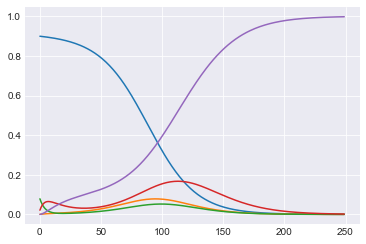

In [6]:
ref_traj = model(R, T, start, 0.1)[0]
plt.plot(ref_traj[:,0])

## Sample SEIR Trajectories 

Use different compartment dist

In [7]:
# compartment parameters
compartments = ['E', 'I', 'R']
infections_compartments = [1]
C = len(compartments)
tmat = maxentep.TransitionMatrix(1.0, compartments)
tmat.add_norm_dist('E', 'I', 7, 2)
tmat.add_norm_dist('I', 'R', 11, 4)
T = tmat.sample(1)[0]
T

array([[0.86128513, 0.13871487, 0.        ],
       [0.        , 0.72079714, 0.27920286],
       [0.        , 0.        , 1.        ]])

In [8]:
def sample_rmat(N, loc=1.0):
    M = 4
    R = np.abs(np.random.normal(size=(N,M,M), loc=loc))
    R = R / np.sum(R, axis=2).reshape(N,M,1)
    return R
rs = sample_rmat(2)
np.sum(rs[0], axis=1)

array([1., 1., 1., 1.])

In [9]:
# starting fractions
def make_starts(N):
    start = np.zeros((N, M, C))
    # pick 2 starting patches
    seeds = [[0, 1]]
    for i in range(N):
        for j in np.random.randint(0, M, size=1):
            start[i,j,compartments.index('I')] = np.abs(ss.norm.rvs(loc=0.05, scale=0.15))
    return start
make_starts(1)

array([[[0.        , 0.        , 0.        ],
        [0.        , 0.07210033, 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]]])

In [11]:
import tqdm
#tf.debugging.enable_check_numerics()
N = 512
batches = 16
outs = []
for b in tqdm.tqdm(range(batches)):
    start = make_starts(N)
    Rmat = sample_rmat(N)
    infect = maxentep.contact_infection_func(infections_compartments)
    T = tmat.sample(N)
    model = maxentep.MetaModel(infect, 250)
    outs.append(model(Rmat, T, start, [np.random.uniform(0.01,0.25) for _ in range(N)]))
trajs = np.concatenate(outs, axis=0)
print(trajs.shape)

  0%|                                                                                  | 0/16 [00:00<?, ?it/s]


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



  6%|████▋                                                                     | 1/16 [00:00<00:10,  1.46it/s]


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



 12%|█████████▎                                                                | 2/16 [00:01<00:09,  1.49it/s]


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



 19%|█████████████▉                                                            | 3/16 [00:01<00:08,  1.49it/s]


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



 25%|██████████████████▌                                                       | 4/16 [00:02<00:08,  1.45it/s]


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



 31%|███████████████████████▏                                                  | 5/16 [00:03<00:07,  1.44it/s]


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



 38%|███████████████████████████▊                                              | 6/16 [00:04<00:06,  1.46it/s]


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



 44%|████████████████████████████████▍                                         | 7/16 [00:04<00:06,  1.45it/s]


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



 50%|█████████████████████████████████████                                     | 8/16 [00:05<00:05,  1.46it/s]


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



 56%|█████████████████████████████████████████▋                                | 9/16 [00:06<00:04,  1.42it/s]


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



 62%|█████████████████████████████████████████████▋                           | 10/16 [00:06<00:04,  1.44it/s]


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



 69%|██████████████████████████████████████████████████▏                      | 11/16 [00:07<00:03,  1.44it/s]


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



 75%|██████████████████████████████████████████████████████▊                  | 12/16 [00:08<00:02,  1.41it/s]


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



 81%|███████████████████████████████████████████████████████████▎             | 13/16 [00:09<00:02,  1.41it/s]


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



 88%|███████████████████████████████████████████████████████████████▉         | 14/16 [00:09<00:01,  1.42it/s]


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



 94%|████████████████████████████████████████████████████████████████████▍    | 15/16 [00:10<00:00,  1.43it/s]


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



100%|█████████████████████████████████████████████████████████████████████████| 16/16 [00:11<00:00,  1.45it/s]

(8192, 250, 4, 4)


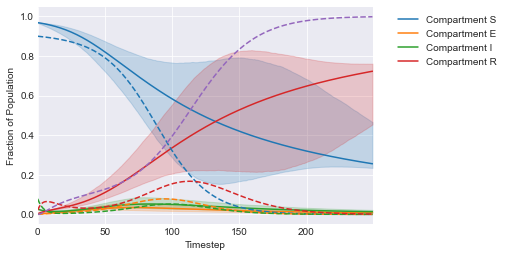

In [12]:
full_compartments = ['S'] + compartments
maxentep.traj_quantile(trajs[:,:,0,:], names=full_compartments, plot_means=True)
plt.plot(ref_traj[:,0], linestyle='--')
plt.show()


## Make restraints from reference trajectory


Using only first half of trajectory and use the R compartment in patch 0

In [13]:
npoints = 2
#prior = maxentep.Laplace(0.025)
prior = maxentep.EmptyPrior() # make empty to compare with regressed
restraints, plot_fxns = maxentep.traj_to_restraints(ref_traj[:125,:,:], [0, -1], npoints, prior, noise=0.01)

38 0.10251011 0.09728696926337478
31 0.08915717 0.09425185932083316


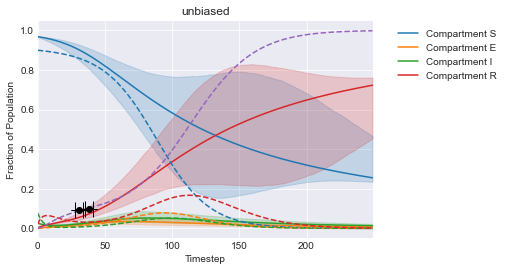

In [14]:
maxentep.traj_quantile(trajs[:,:,0,:], names=full_compartments, plot_means=True)
plt.title('unbiased')
plt.plot(ref_traj[:,0], linestyle='--')
for i,pf in enumerate(plot_fxns):
    pf(plt.gca(), 0)
plt.show()

In [15]:
me_model = maxentep.MaxentModel(restraints)
me_model.compile(tf.keras.optimizers.Adam(learning_rate=1e-2), 'mean_squared_error')

In [16]:
history = me_model.fit(trajs, batch_size=8,epochs=32)

Epoch 1/32
256/256 [==============================] - 0s 777us/step - loss: 9.1165e-04
Epoch 2/32
256/256 [==============================] - 0s 766us/step - loss: 8.2578e-04
Epoch 3/32
256/256 [==============================] - 0s 766us/step - loss: 7.8887e-04
Epoch 4/32
256/256 [==============================] - 0s 758us/step - loss: 7.8025e-04
Epoch 5/32
256/256 [==============================] - 0s 812us/step - loss: 8.6916e-04
Epoch 6/32
256/256 [==============================] - 0s 809us/step - loss: 8.7009e-04
Epoch 7/32
256/256 [==============================] - 0s 789us/step - loss: 8.9809e-04
Epoch 8/32
256/256 [==============================] - 0s 824us/step - loss: 7.9076e-04
Epoch 9/32
256/256 [==============================] - 0s 875us/step - loss: 8.6596e-04
Epoch 10/32
256/256 [==============================] - 0s 832us/step - loss: 7.9285e-04
Epoch 11/32
256/256 [==============================] - 0s 809us/step - loss: 9.2663e-04
Epoch 12/32
256/256 [====================

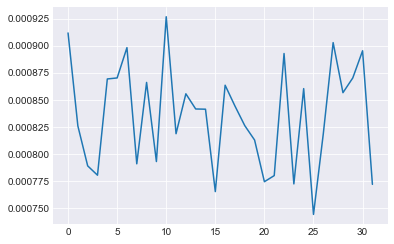

In [17]:
plt.plot(history.history['loss'])

In [18]:
me_model.lambdas

<tf.Variable 'maxent-lambda:0' shape=(2,) dtype=float32, numpy=array([-1.1182663 , -0.86325437], dtype=float32)>

## Direct Regression of Model

In [19]:
T = tmat.sample(1)[0]
R = sample_rmat(1)[0]
s = make_starts(1)[0]
infect = maxentep.ContactInfectionLayer(0.1, infections_compartments)
print(T.shape, R.shape, s.shape)
# make "agreement" function
def agreement(traj, rs=restraints):
    s = 0
    for r in rs:
        s += r(traj[0])**2
    return s
rmodel = maxentep.TrainableMetaModel(s, R, T, infect, 250, agreement)

(3, 3) (4, 4) (4, 3)


In [20]:
rmodel.compile(optimizer=tf.keras.optimizers.Adam(0.01))
utraj = rmodel.get_traj()
rmodel.fit(500)
rtraj = rmodel.get_traj()

500/500 [==============================] - 43s 86ms/step - loss: 1.7449e-05 - output_2_loss: 1.7449e-05


## Now visualize results

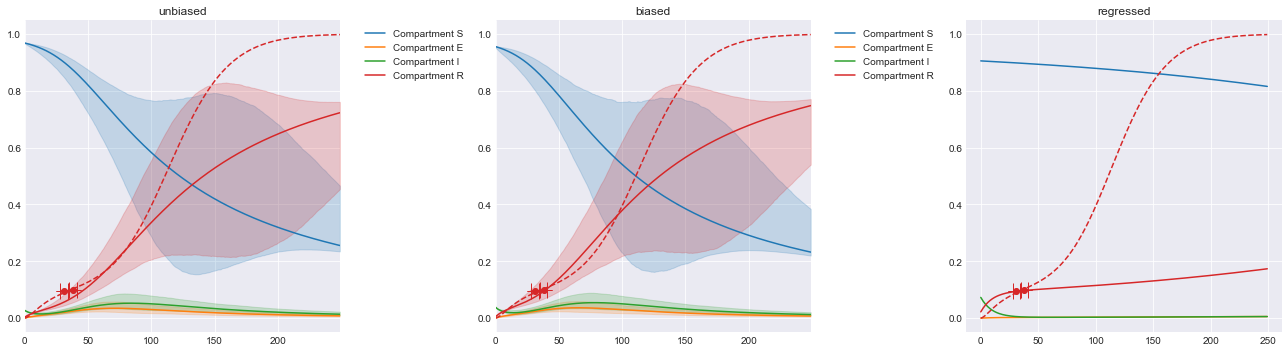

In [21]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18,5))
axs[0].set_title('unbiased')
maxentep.traj_quantile(trajs[:,:,0,:], names=full_compartments, ax=axs[0])
axs[0].plot(ref_traj[:,0,-1], linestyle='--', color='C3')
for i,pf in enumerate(plot_fxns):
    pf(axs[0], me_model.lambdas[i], color='C3')

axs[1].set_title('biased')
maxentep.traj_quantile(trajs[:,:,0,:], weights=me_model.traj_weights, names=full_compartments, ax=axs[1])
axs[1].plot(ref_traj[:,0,-1], linestyle='--', color='C3')
for i,pf in enumerate(plot_fxns):
    pf(axs[1], me_model.lambdas[i], color='C3')
plt.tight_layout()

axs[2].set_title('regressed')
axs[2].plot(rtraj[0,:,0,:])
axs[2].plot(ref_traj[:,0,-1], linestyle='--', color='C3')
for i,pf in enumerate(plot_fxns):
    pf(axs[2], 1, color='C3')

plt.tight_layout()
plt.savefig('traj_match.png', dpi=300)
plt.show()